# Settings

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from numpy import linspace
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from nltk.tokenize import sent_tokenize
import nltk
import csv
import random
from tqdm import tqdm
import os

nltk.download('punkt')  # Download the Punkt tokenizer for sentence splitting

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Replace with your Google Drive folder path
working_directory = '/content/drive/MyDrive/Colab Notebooks/dh2024'

# Set data directories
folder_path = os.path.join(working_directory, "/content/drive/MyDrive/Colab Notebooks/dh2024/dh2024/drama-data_endgame")
print(folder_path)
# Check if the output directory exists, create if not
output_folder_path = os.path.join(working_directory, "sentiment_analysis_output")
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

/content/drive/MyDrive/Colab Notebooks/dh2024/dh2024/drama-data_endgame


# Functions

In [6]:
# Function to get sentiment scores
def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    scores = torch.nn.functional.softmax(logits, dim=1).tolist()[0]
    return scores

def get_single_sentiment_score(scores): # Get the single sentiment score
    # Sores are a list of probabilities for each category (e.g., [0.1, 0.2, 0.3, 0.2, 0.2])
    categories = [1, 2, 3, 4, 5]
    weighted_sum = sum(score * category for score, category in zip(scores, categories))
    return weighted_sum / sum(scores)  # Normalize by the sum of scores to get the average

def get_single_sentiment_score_from_text(text): # Get the single sentiment score from the text
    scores = get_sentiment_scores(text)
    single_score = get_single_sentiment_score(scores)
    return single_score

def rescale(l): # Rescale the x-axis
    x = np.linspace(1/len(l), 1, len(l))*100
    return x

def visualize_sentiment_score_scaled_smoothed(all_scores, frac=0.05): # Visualize the sentiment scores for all files
    plt.figure(figsize=(10, 5))
    for filename, scores in all_scores.items():
        x_scaled = rescale(list(range(0, len(scores))))
        y = scores
        smoothed = lowess(y, x_scaled, frac=frac)
        plt.plot(smoothed[:, 0], smoothed[:, 1], label=f"{filename[:-4]}")
    plt.title('Sentiment Scores for Text Files')
    plt.ylabel('Sentiment Score')
    plt.xlabel('Narrative Time')
    plt.legend()
    plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    # save the plot in the output folder
    plt.savefig(os.path.join(output_folder_path, 'sentiment_scores_combined.png'))

def visualize_sentiment_score_scaled_smoothed_interactive(all_scores, frac=0.05, include_filenames=None, exclude_filenames=None):
    # Initialize an empty figure for plotting
    fig = go.Figure()

    # Determine which filenames to process based on include/exclude lists
    filenames_to_process = all_scores.keys()
    if include_filenames is not None:
        filenames_to_process = [fn for fn in filenames_to_process if fn in include_filenames]
    elif exclude_filenames is not None:
        filenames_to_process = [fn for fn in filenames_to_process if fn not in exclude_filenames]

    print(f"Following files are included: {filenames_to_process}")

    for filename in filenames_to_process:
        scores = all_scores[filename]
        # Apply the rescale function to the x-axis values
        x_scaled = rescale(list(range(len(scores))))
        y = scores
        # Apply LOWESS to smooth the scores
        smoothed = lowess(y, x_scaled, frac=frac)

        # Add a line to the figure for each set of scores
        fig.add_trace(go.Scatter(
            x=smoothed[:, 0],  # X-axis values after rescaling
            y=smoothed[:, 1],  # Y-axis values after smoothing
            mode='lines',  # Line plot
            name=filename  # Legend name
        ))

    # Update the layout of the figure to add titles and axis labels
    fig.update_layout(
        title='Sentiment Scores for Text Files',
        xaxis_title='Narrative Time',
        yaxis_title='Sentiment Score',
        legend_title='Text Files',
        template='plotly_white',
    )

    # Show the figure
    fig.show()

    # Save the figure as an HTML file if an output path is provided
    # Convert list to string and replace spaces with underscores
    # Abbreviate filenames and then combine
    filename_combined = "_".join(''.join(word[0] for word in filename.split()) for filename in filenames_to_process)
    #filename_combined = "_".join(filenames_to_process).replace(" ", "_")
    html_file_path = os.path.join(output_folder_path, f"{filename_combined}_sentiment_scores_combined.html")
    fig.write_html(html_file_path)
    print(f"Interactive plot saved to {html_file_path}")

def split_into_sentences_nltk(text): # Split the text into sentences using NLTK
    sentences = sent_tokenize(text)
    return sentences

def split_into_sentences_regex(text): # Split the text into sentences using regular expressions
    # Regular expression to match sentence endings
    sentence_endings = re.compile(r'[.!?]"?\s+|\s*$')
    sentences = sentence_endings.split(text)
    return sentences

def smooth(y, frac=0.05): # Smoothing function
  x_scaled = rescale(list(range(0, len(y))))
  smoothed = lowess(y, x_scaled, frac=frac)
  smoothed_x = smoothed[:, 0]
  smoothed_y = smoothed[:, 1]
  return smoothed_y

def pearson_corr(y1, y2): # Pearson correlation function
    # Scale the x-values to a range of 0-1
    x_scaled1 = np.linspace(0, 1, len(y1))
    x_scaled2 = np.linspace(0, 1, len(y2))

    # Define a common set of x-values for interpolation
    # This range should cover the extents of both x_scaled1 and x_scaled2
    common_x = linspace(min(min(x_scaled1), min(x_scaled2)), max(max(x_scaled1), max(x_scaled2)), num=max(len(y1), len(y2)))

    # Interpolate y-values to the common set of x-values
    interp_y_values1 = np.interp(common_x, x_scaled1, y1)
    interp_y_values2 = np.interp(common_x, x_scaled2, y2)

    # Calculate Pearson correlation on the interpolated y-values
    pearson_corr = pearsonr(interp_y_values1, interp_y_values2)
    return pearson_corr

def process_txt(file_path): # Process the text file
    # Read the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    return text

def get_correlation_matrix(all_sentiment_scores): # Calculate the correlation matrix
    # Initialize an empty DataFrame with keys as both the row and column labels
    labels = list(all_sentiment_scores.keys())
    corr_matrix = pd.DataFrame(index=labels, columns=labels)

    # Calculate Pearson correlation for all unique pairs and fill in the matrix
    for key1 in labels:
        for key2 in labels:
            if key1 == key2:
                # Correlation of a series with itself is 1
                corr_matrix.loc[key1, key2] = 1
            elif pd.isnull(corr_matrix.loc[key1, key2]):
                # Calculate correlation only if it hasn't been calculated before
                corr_result = pearson_corr(smooth(all_sentiment_scores[key1]), smooth(all_sentiment_scores[key2]))
                # Assume the correlation value can be accessed with .correlation or adjust as needed
                corr = corr_result.correlation if hasattr(corr_result, 'correlation') else corr_result
                # Fill both (key1, key2) and (key2, key1) to maintain symmetry
                corr_matrix.loc[key1, key2] = corr
                corr_matrix.loc[key2, key1] = corr
    return corr_matrix

def visualize_heatmap(corr_matrix): # Visualize the correlation matrix
    # Convert all entries in the DataFrame to floats
    corr_matrix_numeric = corr_matrix.astype(float)

    # Now, try creating the heatmap again
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Heatmap of Correlation Matrix')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=45)
    plt.tight_layout()  # Adjust layout to not cut off labels
    # save the plot in the output folder
    plt.savefig(os.path.join(output_folder_path, 'correlation_heatmap.png'))

def visualize_heatmap_interactive(corr_matrix): # Visualize the correlation matrix interactively
    # Convert all entries in the DataFrame to floats
    corr_matrix_numeric = corr_matrix.astype(float)

    # Prepare data for the heatmap
    labels = corr_matrix.columns.values
    values = corr_matrix_numeric.values

    # Create the heatmap using Plotly's Graph Objects
    fig = go.Figure(data=go.Heatmap(
        z=values,  # Correlation values
        x=labels,  # X-axis labels
        y=labels,  # Y-axis labels
        colorscale='RdBu',  # Color scale
        zmid=0,  # Center the color scale at 0
        reversescale=True,  # Reverse the color scale to match 'coolwarm'
        colorbar=dict(title='Correlation'),  # Color bar customization
        ))

    # Update layout
    fig.update_layout(
        title='Heatmap of Correlation Matrix',
        xaxis=dict(tickmode='array', tickvals=list(range(len(labels))), ticktext=labels, tickangle=45),
        yaxis=dict(tickmode='array', tickvals=list(range(len(labels))), ticktext=labels, tickangle=45),
        autosize=True,
        margin=dict(l=50, r=50, b=100, t=100, pad=4)
    )

    # Show the figure
    fig.show()

    # Save the figure as an HTML file if an output path is provided
    if output_folder_path:
        html_file_path = os.path.join(output_folder_path, 'correlation_heatmap.html')
        fig.write_html(html_file_path)
        print(f"Interactive plot saved to {html_file_path}")

def visualize_pca(corr_matrix): # Visualize PCA
    # Convert the correlation matrix to a NumPy array if it's not already
    corr_matrix_np = corr_matrix.to_numpy()

    # Initialize PCA, specifying we want to reduce to 2 dimensions
    pca = PCA(n_components=2)

    # Fit and transform the data
    pca_result = pca.fit_transform(corr_matrix_np)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    for i, label in enumerate(corr_matrix.index):
        plt.text(pca_result[i, 0], pca_result[i, 1], label)
    plt.title('PCA of Correlation Matrix')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    # save the plot in the output folder
    plt.savefig(os.path.join(output_folder_path, 'pca.png'))

def visualize_pca_interactive(corr_matrix): # Visualize PCA interactively
    # Convert the correlation matrix to a NumPy array if it's not already
    corr_matrix_np = corr_matrix.to_numpy()

    # Initialize PCA, specifying we want to reduce to 2 dimensions
    pca = PCA(n_components=2)

    # Fit and transform the data
    pca_result = pca.fit_transform(corr_matrix_np)

    # Prepare labels for hover information
    labels = corr_matrix.index

    # Create a Plotly scatter plot
    fig = go.Figure()

    # Add scatter plot points
    fig.add_trace(go.Scatter(
        x=pca_result[:, 0],
        y=pca_result[:, 1],
        mode='markers+text',
        text=labels,
        textposition="top center",
        marker=dict(size=10, color='LightSkyBlue', line=dict(width=2, color='DarkSlateGrey'))
    ))

    # Update layout with titles and axis labels
    fig.update_layout(
        title='PCA of Correlation Matrix',
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        plot_bgcolor='white',
        autosize=False,
        width=800,
        height=600
    )

    # Show the figure
    fig.show()

    # Save the figure as an HTML file if an output path is provided
    if output_folder_path:
        html_file_path = os.path.join(output_folder_path, 'pca_interactive.html')
        fig.write_html(html_file_path)
        print(f"Interactive plot saved to {html_file_path}")

def visualize_tsne(corr_matrix): # Visualize t-SNE
    # If n_samples is more than 5, use t-SNE to visualize the correlation matrix
    if corr_matrix.shape[0] > 5:
        # Convert the correlation matrix to a NumPy array if it's not already
        corr_matrix_np = corr_matrix.to_numpy()

        # Assuming corr_matrix_np is the NumPy array of your correlation matrix
        n_samples = corr_matrix_np.shape[0]

        # Choose a perplexity value less than n_samples. If n_samples is very small, you might need to adjust this even lower.
        perplexity_value = min(30, max(5, n_samples // 2 - 1))

        tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)

        # Fit and transform the data
        tsne_result = tsne.fit_transform(corr_matrix_np)

        # Plot the results
        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
        for i, label in enumerate(corr_matrix.index):
            plt.text(tsne_result[i, 0], tsne_result[i, 1], label)
        plt.title('t-SNE of Correlation Matrix')
        plt.xlabel('t-SNE Feature 1')
        plt.ylabel('t-SNE Feature 2')
        # save the plot in the output folder
        plt.savefig(os.path.join(output_folder_path, 'tsne.png'))

    else:
        print("The number of samples is too small to visualize using t-SNE")

def visualize_tsne_interactive(corr_matrix): # Visualize t-SNE interactively
    # Visualize t-SNE
    if corr_matrix.shape[0] > 5:
        # Convert the correlation matrix to a NumPy array if it's not already
        corr_matrix_np = corr_matrix.to_numpy()

        # Assuming corr_matrix_np is the NumPy array of your correlation matrix
        n_samples = corr_matrix_np.shape[0]

        # Choose a perplexity value less than n_samples.
        perplexity_value = min(30, max(5, n_samples // 2 - 1))

        tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)

        # Fit and transform the data
        tsne_result = tsne.fit_transform(corr_matrix_np)

        # Prepare labels for hover information
        labels = corr_matrix.index

        # Create Plotly figure for the t-SNE scatter plot
        fig = go.Figure()

        # Add scatter plot points
        fig.add_trace(go.Scatter(
            x=tsne_result[:, 0],
            y=tsne_result[:, 1],
            mode='markers+text',
            text=labels,
            textposition="top center",
            marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey'))
        ))

        # Update layout with titles and axis labels
        fig.update_layout(
            title='t-SNE of Correlation Matrix',
            xaxis_title='t-SNE Feature 1',
            yaxis_title='t-SNE Feature 2',
            plot_bgcolor='white',
            autosize=False,
            width=800,
            height=600
        )

        # Show the figure
        fig.show()

        # Save the figure as an HTML file if an output path is provided
        if output_folder_path:
            html_file_path = os.path.join(output_folder_path, 'tsne_interactive.html')
            fig.write_html(html_file_path)
            print(f"Interactive plot saved to {html_file_path}")
    else:
        print("The number of samples is too small to visualize using t-SNE.")

def write_to_csv(data, filename, header1='header1', header2='header2'):
    csv_file_path = os.path.join(output_folder_path, filename) # Construct the full file path
    # Open the file for writing
    with open(csv_file_path, 'w', encoding='utf-8') as file:
        writer = csv.writer(file) # Create a CSV writer
        writer.writerow(['Title', header1, header2]) # Write the header row
        for title, items in data.items(): # Loop through the data
            if isinstance(items, dict): # Check if the items are a dictionary
                for speaker, scores in items.items(): # Loop through the items
                    for score in scores: # Loop through the scores
                        writer.writerow([title, speaker, score]) # Write the title, speaker, and score to the file
            else: # If the items are not a dictionary
                for item in items: # Loop through the items
                    writer.writerow([title, item])
    print(f"Data written to {csv_file_path}") # Print a message to confirm the operation

def main_process(folder_path, output_folder_path, regex=True, frac=0.05, include_filenames=None, exclude_filenames=None):
    all_sentiment_scores = {} # Initialize an empty dictionary to store sentiment scores for all files
    for filename in tqdm(os.listdir(folder_path), desc="Processing files"):
        if filename.endswith('.txt'): # Check if the file is an XML file
            file_path = os.path.join(folder_path, filename) # Construct the full file path
            text = process_txt(file_path) # Process the txt file
            sentiment_scores = [] # Initialize an empty list to store sentiment scores
            scores_and_sentence = [] # Initialize an empty list to store scores and chunks

            if regex:
                sentences = split_into_sentences_regex(text)
            else:
                sentences = split_into_sentences_nltk(text)

            for sentence in sentences:
                single_score = get_single_sentiment_score_from_text(sentence)
                sentiment_scores.append(single_score)
                scores_and_sentence.append((single_score, sentence))

            base_name = os.path.splitext(filename)[0] # Get the base name of the file
            # Create a DataFrame from the scores and sentences
            df = pd.DataFrame(scores_and_sentence, columns=["Sentiment Score", "Chunk"])
            output_path = os.path.join(output_folder_path, f"{base_name}_sentiments_scores_and_sentences.csv")
            df.to_csv(output_path, index=False)
            all_sentiment_scores[base_name] = sentiment_scores # Add the sentiment scores to the dictionary
    return all_sentiment_scores

# Run

In [7]:
#include_filenames = ['avenger','age_of_ultron', 'infinity_war','avengers_endgame']
all_sentiment_scores = main_process(folder_path, output_folder_path, regex=True, frac=0.05, include_filenames=None)

Processing files: 100%|██████████| 3/3 [00:55<00:00, 18.37s/it]


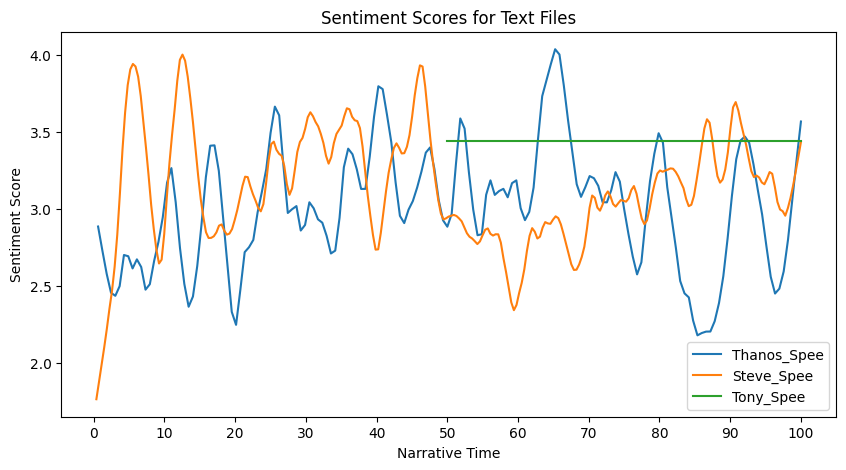

In [8]:
# Visualize the sentiment scores
visualize_sentiment_score_scaled_smoothed(all_sentiment_scores)

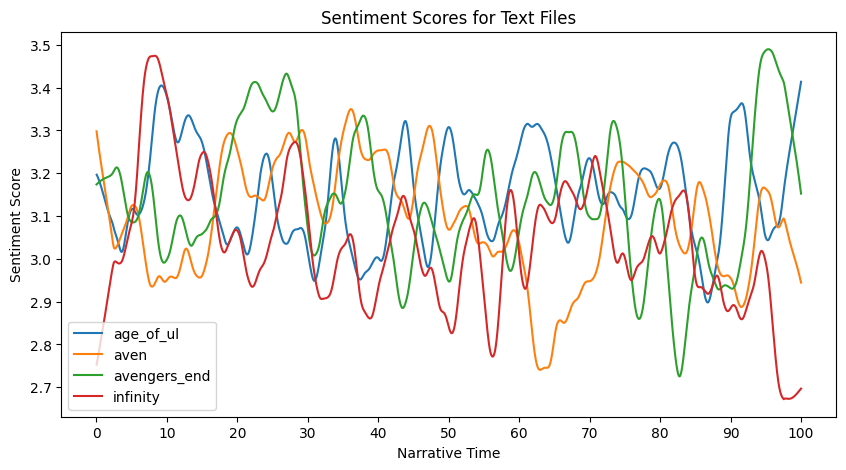

In [ ]:
# Visualize the sentiment scores
visualize_sentiment_score_scaled_smoothed(all_sentiment_scores)

In [ ]:
# Visualize the sentiment scores interactively
print(all_sentiment_scores.keys()) # Print the keys to determine which files to include
# include_filenames=['A Midsummer Nights Dream', 'Alls Well That Ends Well', 'sample', 'sample copy'] # Define the list of files to include
visualize_sentiment_score_scaled_smoothed_interactive(all_sentiment_scores)

dict_keys(['age_of_ultron', 'avengers', 'avengers_endgame', 'infinity_war'])
Following files are included: dict_keys(['age_of_ultron', 'avengers', 'avengers_endgame', 'infinity_war'])


Interactive plot saved to /content/drive/MyDrive/Colab Notebooks/dh2024/sentiment_analysis_output/a_a_a_i_sentiment_scores_combined.html


In [ ]:
# Calculate the correlation matrix
corr_matrix = get_correlation_matrix(all_sentiment_scores)

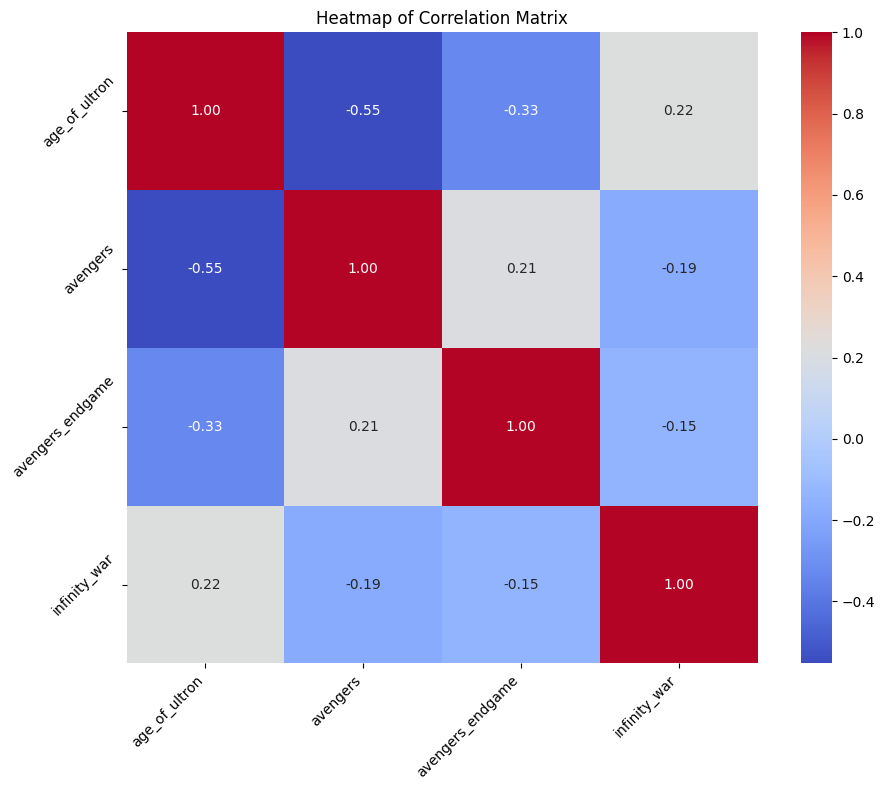

In [ ]:
# Visualize the correlation matrix
visualize_heatmap(corr_matrix)

In [ ]:
# Visualize the correlation matrix interactively
visualize_heatmap_interactive(corr_matrix)

Interactive plot saved to /content/drive/MyDrive/Colab Notebooks/dh2024/sentiment_analysis_output/correlation_heatmap.html


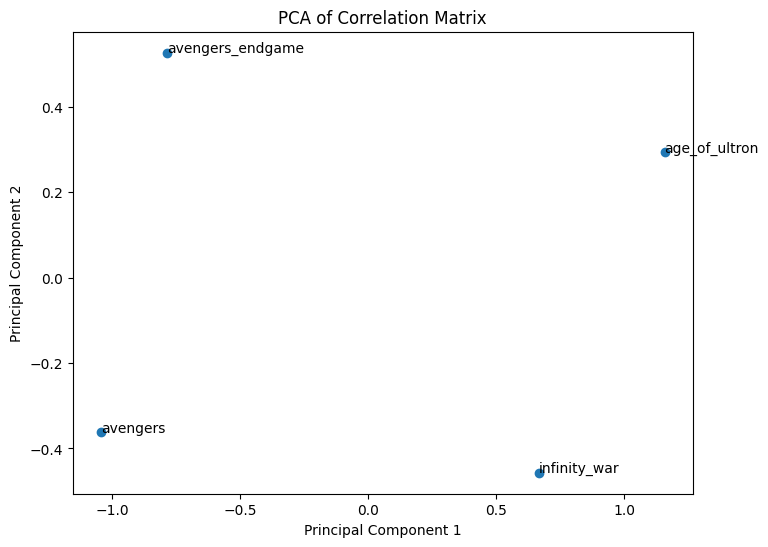

In [ ]:
# Visualize PCA
visualize_pca(corr_matrix)

In [ ]:
# Visualize PCA interactively
visualize_pca_interactive(corr_matrix)

Interactive plot saved to /content/drive/MyDrive/Colab Notebooks/dh2024/sentiment_analysis_output/pca_interactive.html


In [ ]:
# Visualize t-SNE
visualize_tsne(corr_matrix)

The number of samples is too small to visualize using t-SNE


In [ ]:
# Visualize t-SNE interactively
visualize_tsne_interactive(corr_matrix)

The number of samples is too small to visualize using t-SNE.
